## Multi-Fidelity BO with Discrete Fidelities using KG

In this tutorial, we show how to do multi-fidelity BO with discrete fidelities based on [1], where each fidelity is a different "information source." This tutorial uses the same setup as the [continuous multi-fidelity BO tutorial](https://botorch.org/tutorials/multi_fidelity_bo), except with discrete fidelity parameters that are interpreted as multiple information sources.

We use a GP model with a single task that models the design and fidelity parameters jointly. In some cases, where there is not a natural ordering in the fidelity space, it may be more appropriate to use a multi-task model (with, say, an ICM kernel). We will provide a tutorial once this functionality is in place.

[1] [M. Poloczek, J. Wang, P.I. Frazier. Multi-Information Source Optimization. NeurIPS, 2017](https://papers.nips.cc/paper/2017/file/df1f1d20ee86704251795841e6a9405a-Paper.pdf)

[2] [J. Wu, S. Toscano-Palmerin, P.I. Frazier, A.G. Wilson. Practical Multi-fidelity Bayesian Optimization for Hyperparameter Tuning. Conference on Uncertainty in Artificial Intelligence (UAI), 2019](https://arxiv.org/pdf/1903.04703.pdf)

### Set dtype and device

In [62]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Problem setup

We'll consider the Augmented Hartmann multi-fidelity synthetic test problem. This function is a version of the Hartmann6 test function with an additional dimension representing the fidelity parameter; details are in [2]. The function takes the form $f(x,s)$ where $x \in [0,1]^6$ and $s \in \{0.5, 0.75, 1\}$. The target fidelity is 1.0, which means that our goal is to solve $\max_x f(x,1.0)$ by making use of cheaper evaluations $f(x,s)$ for $s \in \{0.5, 0.75\}$. In this example, we'll assume that the cost function takes the form $5.0 + s$, illustrating a situation where the fixed cost is $5.0$.

In [63]:
from botorch.test_functions.multi_fidelity import AugmentedHartmann
from benchmarks import DataModelBenchmark


# problem = AugmentedHartmann(negate=True).to(**tkwargs)
# fidelities = torch.tensor([0.5, 0.75, 1.0], **tkwargs)

METRIC_NAMES = {
    0: "Train Cross Entropy",
    1: "Common Crawl Cross Entropy",
    2: "C4 Cross Entropy",
    3: "Wikipedia Cross Entropy",
    4: "Stack Exchange Cross Entropy",  # Current default
    5: "Github Cross Entropy",
    6: "ArXiv Cross Entropy",
    7: "Book Cross Entropy",
    8: "Hellaswag Accuracy",
    9: "PIQA Accuracy",
    10: "ARC Easy Accuracy"
}

metric_num = 4
metric_name = METRIC_NAMES[metric_num]
print(f"Instantiating benchmark with y=metric {metric_name}")

problem = DataModelBenchmark(metric_index=metric_num)  # 3 for Wikipedia Cross Entropy
fidelities = torch.tensor([100.0, 150.0, 196.0], **tkwargs)

Instantiating benchmark with y=metric Stack Exchange Cross Entropy
Instantiating benchmark with y=metric Stack Exchange Cross Entropy


/Users/andrewsiah/Documents/research/data-recipes/opt_algos/data_model.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_loca

#### Model initialization

We use a `SingleTaskMultiFidelityGP` as the surrogate model, which uses a kernel from [2] that is well-suited for multi-fidelity applications. The `SingleTaskMultiFidelityGP` models the design and fidelity parameters jointly, so its domain is $[0,1]^7$.

In [64]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


def generate_initial_data(n=16):
    # generate training data
    train_x = torch.rand(n, 5, **tkwargs) * 6.0 - 3.0  # Scale to [-3.0, 3.0]
    train_f = fidelities[torch.randint(3, (n, 1))]
    train_x_full = torch.cat((train_x, train_f), dim=1)
    # Call problem.func instead of problem directly, converting fidelity to int
    train_obj = -torch.tensor([problem.func(int(z.item()), x.tolist())[-1][1] for x, z in zip(train_x, train_f)], **tkwargs).unsqueeze(-1)
    
    return train_x_full, train_obj


def initialize_model(train_x, train_obj):
    model = SingleTaskMultiFidelityGP(
        train_x, train_obj, outcome_transform=Standardize(m=1), data_fidelities=[5]
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function to construct the MFKG acquisition function
The helper function illustrates how one can initialize an $q$MFKG acquisition function. In this example, we assume that the affine cost is known. We then use the notion of a `CostAwareUtility` in BoTorch to scalarize the "competing objectives" of information gain and cost. The MFKG acquisition function optimizes the ratio of information gain to cost, which is captured by the `InverseCostWeightedUtility`.

In order for MFKG to evaluate the information gain, it uses the model to predict the function value at the highest fidelity after conditioning on the observation. This is handled by the `project` argument, which specifies how to transform a tensor `X` to its target fidelity. We use a default helper function called `project_to_target_fidelity` to achieve this.

An important point to keep in mind: in the case of standard KG, one can ignore the current value and simply optimize the expected maximum posterior mean of the next stage. However, for MFKG, since the goal is optimize information *gain* per cost, it is important to first compute the current value (i.e., maximum of the posterior mean at the target fidelity). To accomplish this, we use a `FixedFeatureAcquisitionFunction` on top of a `PosteriorMean`.

In [65]:
# Import required BoTorch modules
from botorch import fit_gpytorch_mll
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition import PosteriorMean
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.utils import project_to_target_fidelity

# # Define bounds for the optimization space - creates a tensor with lower and upper bounds
# bounds = torch.tensor([[0.0] * problem.dim, [1.0] * problem.dim], **tkwargs)
bounds = torch.tensor([
    [-3.0, -3.0, -3.0, -3.0, -3.0, 1.0],    # lower bounds: 5 input dims + fidelity
    [3.0, 3.0, 3.0, 3.0, 3.0, 196.0]        # upper bounds: 5 input dims + fidelity
], **tkwargs)

# # Specify that dimension 6 (the fidelity parameter) should be set to 1.0 for final evaluation
# target_fidelities = {6: 1.0}

# Specify that dimension 5 (the fidelity parameter) should be set to 196.0 for final evaluation
target_fidelities = {5: 196.0}


# Create cost model that assigns weight of 1.0 to fidelity dimension and adds fixed cost of 5.0
cost_model = AffineFidelityCostModel(fidelity_weights={5: 1.0}, fixed_cost=1000.0)

# Create utility function that considers both information gain and cost
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

# Helper function to project points to target fidelity
def project(X):
    return project_to_target_fidelity(X=X, target_fidelities=target_fidelities)


# Function to create Multi-Fidelity Knowledge Gradient acquisition function
def get_mfkg(model):
    # First get current best value at highest fidelity
    # Create acquisition function that fixes fidelity to 1.0 and looks at posterior mean
    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=6,  # Total dimensions including fidelity (5 + 1)
        columns=[5],  # Fix fidelity dimension
        values=[196.0],  # Fix fidelity to 196.0
    )

    # Optimize to find current best value at highest fidelity  [']
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:, :-1],  # Exclude fidelity dimension
        q=1,
        num_restarts=10 if not SMOKE_TEST else 2,
        raw_samples=1024 if not SMOKE_TEST else 4,
        options={"batch_limit": 10, "maxiter": 200},
    )

    # Create and return MFKG acquisition function
    return qMultiFidelityKnowledgeGradient(
        model=model,
        num_fantasies=128 if not SMOKE_TEST else 2,  # Number of fantasy points
        current_value=current_value,  # Pass in current best value
        cost_aware_utility=cost_aware_utility,  # Consider cost when making decisions
        project=project,  # How to project to target fidelity
    )


#### Define a helper function that performs the essential BO step
This helper function optimizes the acquisition function and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. The function `optimize_acqf_mixed` sequentially optimizes the acquisition function over $x$ for each value of the fidelity $s \in \{0, 0.5, 1.0\}$.

In [66]:
from botorch.optim.optimize import optimize_acqf_mixed


torch.set_printoptions(precision=3, sci_mode=False)

NUM_RESTARTS = 5 if not SMOKE_TEST else 2
RAW_SAMPLES = 128 if not SMOKE_TEST else 4
BATCH_SIZE = 4


def optimize_mfkg_and_get_observation(mfkg_acqf):
    """Optimizes MFKG and returns a new candidate, observation, and cost."""

    candidates, _ = optimize_acqf_mixed(
        acq_function=mfkg_acqf,
        bounds=bounds,
        fixed_features_list=[ {5: 100.0}, {5: 150.0}, {5: 196.0}],
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values
    cost = cost_model(candidates).sum()
    new_x = candidates.detach()
    # Call problem.func instead of problem directly, converting fidelity to int
    raw_obj = torch.tensor([problem.func(int(z.item()), x.tolist())[-1][1] for x, z in zip(new_x[:, :-1], new_x[:, -1])], **tkwargs).unsqueeze(-1)
    new_obj = -raw_obj
    print(f"candidates:\n{new_x}\n")
    print(f"observations:\n{new_obj}\n\n")
    return new_x, new_obj, cost

### Perform a few steps of multi-fidelity BO
First, let's generate some initial random data and fit a surrogate model.

In [67]:
feature_names = {
    0: "RedPajamaWikipedia",
    1: "RedPajamaStackExchange",
    2: "RedPajamaGithub",
    3: "RedPajamaArXiv",
    4: "RedPajamaBook",
}

train_x, train_obj = generate_initial_data(n=16)
print(f"train_x:\n{train_x}\n")
print(f"train_obj:\n{train_obj}\n")


train_x:
tensor([[    -1.617,     -2.035,      2.579,     -1.224,      1.570,    196.000],
        [    -0.188,      0.836,     -1.416,     -2.534,     -2.414,    100.000],
        [     1.909,      2.988,      2.160,      0.208,     -1.540,    196.000],
        [    -1.533,     -0.664,     -0.900,      1.338,      1.165,    196.000],
        [    -1.193,     -2.346,     -2.851,     -0.089,      1.068,    100.000],
        [     0.489,      0.180,     -1.901,      1.042,     -2.089,    196.000],
        [     2.539,     -1.407,     -2.388,     -1.174,     -0.867,    150.000],
        [     0.450,      1.507,     -0.587,     -0.433,      0.437,    196.000],
        [     0.212,     -2.629,      1.344,      2.128,      1.531,    196.000],
        [    -2.351,      2.295,      1.568,     -2.880,     -1.104,    100.000],
        [    -2.162,      2.715,     -0.611,      0.113,     -2.301,    100.000],
        [    -1.440,     -0.769,     -2.892,      0.611,     -2.544,    150.000],
       

In [68]:
print(f"problem.metric_index:\n{problem.metric_index}\n")


problem.metric_index:
4



We can now use the helper functions above to run a few iterations of BO.

In [69]:
cumulative_cost = 0.0
N_ITER = 3 if not SMOKE_TEST else 1

for i in range(N_ITER):
    mll, model = initialize_model(train_x, train_obj)
    fit_gpytorch_mll(mll)
    mfkg_acqf = get_mfkg(model)
    new_x, new_obj, cost = optimize_mfkg_and_get_observation(mfkg_acqf)
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    cumulative_cost += cost

/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


candidates:
tensor([[     0.439,     -0.858,     -0.812,      2.012,     -1.869,    196.000],
        [     2.654,     -0.035,      1.370,      2.748,      0.602,    100.000],
        [    -1.943,      1.067,      1.524,     -1.413,      2.692,    100.000],
        [    -1.515,     -1.180,      2.106,      2.201,      2.610,    100.000]],
       dtype=torch.float64)

observations:
tensor([[-0.948],
        [-1.063],
        [-0.982],
        [-0.980]], dtype=torch.float64)




/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


candidates:
tensor([[    -2.464,      0.181,      0.400,      1.420,      0.521,    196.000],
        [    -2.949,     -1.796,      2.846,      1.102,     -1.038,    196.000],
        [     2.241,      1.619,      1.176,     -0.648,     -0.376,    150.000],
        [    -0.848,     -0.415,     -2.507,      1.052,     -2.751,    196.000]],
       dtype=torch.float64)

observations:
tensor([[-0.903],
        [-0.938],
        [-0.914],
        [-0.897]], dtype=torch.float64)




/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


candidates:
tensor([[  0.907,   0.654,   1.169,  -2.620,   1.503, 100.000],
        [  2.492,  -0.491,  -2.384,   1.324,  -1.862, 196.000],
        [  1.159,  -0.811,  -2.102,   1.590,  -1.588, 100.000],
        [  2.950,  -1.808,  -2.806,  -2.380,  -2.468, 100.000]],
       dtype=torch.float64)

observations:
tensor([[-0.953],
        [-1.083],
        [-1.060],
        [-1.139]], dtype=torch.float64)




### Make a final recommendation
In multi-fidelity BO, there are usually fewer observations of the function at the target fidelity, so it is important to use a recommendation function that uses the correct fidelity. Here, we maximize the posterior mean with the fidelity dimension fixed to the target fidelity of 1.0.

In [70]:
def get_recommendation(model):
    feature_names = {
        0: "RedPajamaWikipedia",
        1: "RedPajamaStackExchange",
        2: "RedPajamaGithub",
        3: "RedPajamaArXiv",
        4: "RedPajamaBook",
    }

    rec_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=6,  # Total dimensions including fidelity (5 + 1)
        columns=[5],  # Fix fidelity dimension
        values=[196.0],  # Fix fidelity to 196.0
    )

    final_rec, _ = optimize_acqf(
        acq_function=rec_acqf,
        bounds=bounds[:, :-1],
        q=1,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )

    final_rec = rec_acqf._construct_X_full(final_rec)

    # Get raw metric value (not negated)
    raw_value = problem.func(int(final_rec[0, -1].item()), final_rec[0, :-1].tolist())[-1][1]
    print(f"recommended point:\n{final_rec}\n\ncross entropy value:\n{raw_value}")
    print(f"optimized objective value (negated cross entropy):\n{-raw_value}")

    # Print the proportions for clarity
    proportions = torch.exp(final_rec[0, :-1]) / torch.sum(torch.exp(final_rec[0, :-1]))
    print("\nData mixture proportions:")
    for i, name in feature_names.items():
        print(f"{name}: {proportions[i]:.3f}")

    return final_rec


In [71]:
input_features = {
    0: "RedPajamaWikipedia",
    1: "RedPajamaStackExchange",
    2: "RedPajamaGithub",
    3: "RedPajamaArXiv",
    4: "RedPajamaBook"}

print(f"For metric of {metric_name}, the best point is:")

final_rec = get_recommendation(model)
print(f"\ntotal cost: {cumulative_cost}\n")
print("--------------------------------")
final_rec = get_recommendation(model)
print(f"\ntotal cost: {cumulative_cost}\n")

For metric of Stack Exchange Cross Entropy, the best point is:
recommended point:
tensor([[  1.555,   2.994,  -2.087,  -1.224,   0.743, 196.000]],
       dtype=torch.float64)

cross entropy value:
0.8624631532889097
optimized objective value (negated cross entropy):
-0.8624631532889097

Data mixture proportions:
RedPajamaWikipedia: 0.174
RedPajamaStackExchange: 0.733
RedPajamaGithub: 0.005
RedPajamaArXiv: 0.011
RedPajamaBook: 0.077

total cost: 13730.0

--------------------------------
recommended point:
tensor([[  0.450,   1.507,  -0.587,  -0.433,   0.437, 196.000]],
       dtype=torch.float64)

cross entropy value:
0.8681785202766874
optimized objective value (negated cross entropy):
-0.8681785202766874

Data mixture proportions:
RedPajamaWikipedia: 0.178
RedPajamaStackExchange: 0.511
RedPajamaGithub: 0.063
RedPajamaArXiv: 0.073
RedPajamaBook: 0.175

total cost: 13730.0



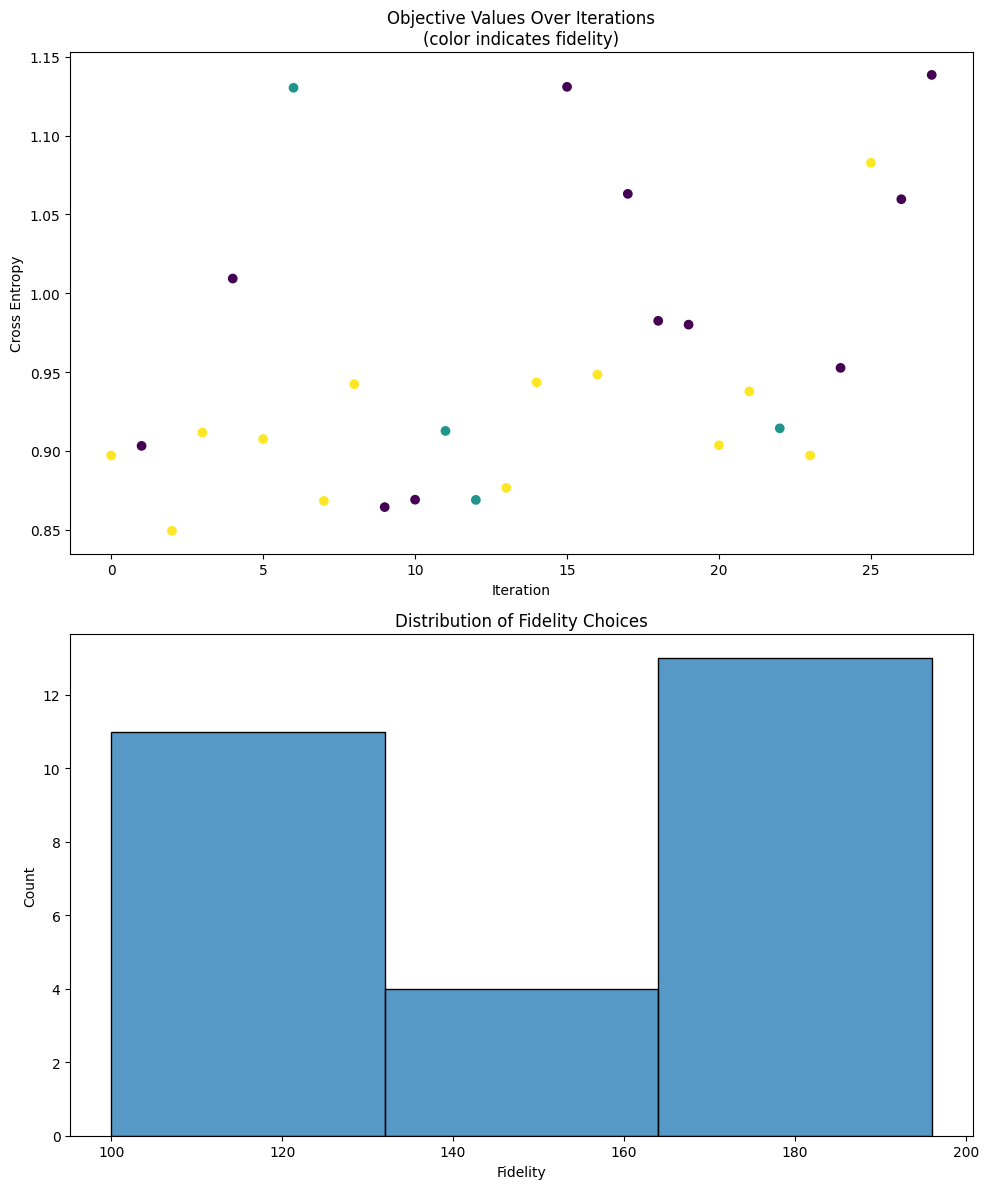

recommended point:
tensor([[  1.909,   2.988,   2.160,   0.208,  -1.540, 196.000]],
       dtype=torch.float64)

cross entropy value:
0.8491846028864463
optimized objective value (negated cross entropy):
-0.8491846028864463

Data mixture proportions:
RedPajamaWikipedia: 0.184
RedPajamaStackExchange: 0.541
RedPajamaGithub: 0.236
RedPajamaArXiv: 0.034
RedPajamaBook: 0.006


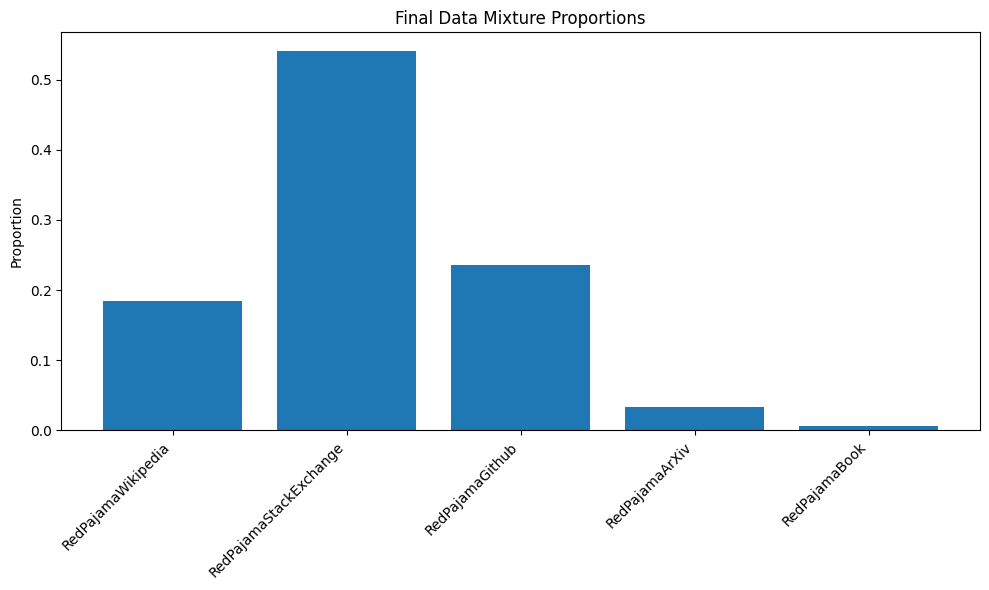

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_optimization_history(train_x, train_obj, title="Optimization History"):
    """Plot the optimization history including objective values and fidelity choices."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot 1: Objective values over iterations
    iterations = np.arange(len(train_obj))
    ax1.scatter(iterations, -train_obj.numpy(), c=train_x[:, -1].numpy(), cmap='viridis')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cross Entropy')
    ax1.set_title('Objective Values Over Iterations\n(color indicates fidelity)')
    
    # Plot 2: Fidelity choices
    fidelities = train_x[:, -1].numpy()
    sns.histplot(data=fidelities, ax=ax2, bins=3)
    ax2.set_xlabel('Fidelity')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Fidelity Choices')
    
    plt.tight_layout()
    plt.show()

def plot_final_mixture(proportions, feature_names):
    """Plot the final mixture proportions as a bar chart."""
    plt.figure(figsize=(10, 6))
    plt.bar(list(feature_names.values()), proportions.numpy())
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Proportion')
    plt.title('Final Data Mixture Proportions')
    plt.tight_layout()
    plt.show()

# Plot the optimization history
plot_optimization_history(train_x, train_obj, title="MFKG Optimization History")

# Plot the final mixture proportions
final_rec = get_recommendation(model)
proportions = torch.exp(final_rec[0, :-1]) / torch.sum(torch.exp(final_rec[0, :-1]))
plot_final_mixture(proportions, input_features)

### Comparison to standard EI (always use target fidelity)
Let's now repeat the same steps using a standard EI acquisition function (note that this is not a rigorous comparison as we are only looking at one trial in order to keep computational requirements low).

In [73]:
from botorch.acquisition import qExpectedImprovement


def get_ei(model, best_f):
    return FixedFeatureAcquisitionFunction(
        acq_function=qExpectedImprovement(model=model, best_f=best_f),
        d=6,  # Total dimensions including fidelity (5 + 1)
        columns=[5],  # Fix fidelity dimension
        values=[196.0],  # Fix fidelity to 196.0
    )

def optimize_ei_and_get_observation(ei_acqf):
    """Optimizes EI and returns a new candidate, observation, and cost."""

    candidates, _ = optimize_acqf(
        acq_function=ei_acqf,
        bounds=bounds[:, :-1],  # Exclude fidelity dimension
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=512,
        options={"batch_limit": 5, "maxiter": 200},
    )

    # add the fidelity parameter
    candidates = ei_acqf._construct_X_full(candidates)

    # observe new values
    cost = cost_model(candidates).sum()
    new_x = candidates.detach()
    # Call problem.func instead of problem directly, converting fidelity to int
    new_obj = torch.tensor([problem.func(int(z.item()), x.tolist())[0][1] for x, z in zip(new_x[:, :-1], new_x[:, -1])], **tkwargs).unsqueeze(-1)
    print(f"candidates:\n{new_x}\n")
    print(f"observations:\n{new_obj}\n\n")
    return new_x, new_obj, cost

In [74]:
cumulative_cost = 0.0

train_x, train_obj = generate_initial_data(n=16)

for _ in range(N_ITER):
    mll, model = initialize_model(train_x, train_obj)
    fit_gpytorch_mll(mll)
    ei_acqf = get_ei(model, best_f=train_obj.max())
    new_x, new_obj, cost = optimize_ei_and_get_observation(ei_acqf)
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    cumulative_cost += cost

/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


candidates:
tensor([[     0.047,      1.982,     -2.148,      2.012,     -0.359,    196.000],
        [    -0.414,      2.753,      1.969,      1.191,      0.652,    196.000],
        [    -2.078,      1.437,      1.147,      0.627,     -2.473,    196.000],
        [    -1.652,      2.584,     -0.701,      2.095,     -1.349,    196.000]],
       dtype=torch.float64)

observations:
tensor([[2.698],
        [2.697],
        [2.743],
        [2.619]], dtype=torch.float64)




/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


candidates:
tensor([[     1.385,     -1.080,      1.456,     -0.388,     -2.032,    196.000],
        [     2.880,      2.843,     -2.000,      0.934,     -2.274,    196.000],
        [     0.716,      2.359,     -2.884,      2.165,     -2.873,    196.000],
        [     0.076,      2.046,     -2.075,      2.025,     -0.304,    196.000]],
       dtype=torch.float64)

observations:
tensor([[2.861],
        [2.602],
        [2.683],
        [2.693]], dtype=torch.float64)




/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/andrewsiah/Documents/research/data-recipes/.venv/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


candidates:
tensor([[    -2.059,      1.553,      1.247,      0.675,     -2.398,    196.000],
        [     1.717,     -2.602,     -1.132,      0.350,     -0.839,    196.000],
        [    -0.149,      1.866,      1.141,     -0.471,     -2.364,    196.000],
        [    -2.045,      1.319,      1.075,      0.614,     -2.394,    196.000]],
       dtype=torch.float64)

observations:
tensor([[2.737],
        [2.703],
        [2.699],
        [2.755]], dtype=torch.float64)




In [75]:
print(f"For metric of {metric_name}, the best point is:")
final_rec = get_recommendation(model)
print(f"\ntotal cost: {cumulative_cost}\n")

For metric of Stack Exchange Cross Entropy, the best point is:
recommended point:
tensor([[     0.062,      2.007,     -2.104,      2.021,     -0.330,    196.000]],
       dtype=torch.float64)

cross entropy value:
0.8799238097040292
optimized objective value (negated cross entropy):
-0.8799238097040292

Data mixture proportions:
RedPajamaWikipedia: 0.063
RedPajamaStackExchange: 0.440
RedPajamaGithub: 0.007
RedPajamaArXiv: 0.447
RedPajamaBook: 0.043

total cost: 14352.0

